In [1]:
seed_num = 2022

from numpy.random import seed
seed(seed_num)
from tensorflow.random import set_seed
set_seed(seed_num)
import tensorflow as tf
tf.keras.utils.set_random_seed(seed_num)
tf.config.experimental.enable_op_determinism()

import numpy as np
import pandas as pd
import os

import anndata as ad
import scanpy as sc
import seaborn as sns

from keras.models import load_model

import time

from SC2Spa import SI, SVA, Vis, PP

pd.options.display.max_columns = 39
%matplotlib inline

/mnt/win1
/mnt/win1/SC2Spa_Notebook/MouseHippocampus_SSV2


# Preprocess

In [2]:
adata = ad.read_h5ad('../Dataset/AdataMH1.h5ad')
adata.var_names_make_unique()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


# Spatial Variance Analysis (SVA)

In [3]:
'''
model = SI.Self_Mapping(adata, sparse = True, model_path = None, x_name = 'xcoord',
             y_name = 'ycoord', root = 'Model_SI/', name = 'SI_Overall', l1_reg = 1e-5, l2_reg = 0,
             dropout = 0.05, epoch = 500, batch_size = 4096, nodes = [4096, 1024, 256, 64, 16, 4],
             lrr_patience = 20, ES_patience = 50, min_lr = 1e-5, save = True, polar = True, seed = seed_num)
'''
model = SI.Self_Mapping(adata, sparse = True, model_path = 'Model_SI/SI_Overall.h5',
                        x_name = 'xcoord', y_name = 'ycoord')

SVA.PrioritizeLPG(adata, Model = model, percent = 0.5, scale_factor = 1e3,
                  Norm = True, x_name = 'xcoord', y_name = 'ycoord')

2022-06-14 23:06:01.668448: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-14 23:06:02.750872: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22071 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-06-14 23:06:05.646750: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2902435692 exceeds 10% of free system memory.
2022-06-14 23:06:12.679911: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2902435692 exceeds 10% of free system memory.
2022-06-14 23:06:15.770790: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2902435692 exc

<keras.layers.core.dense.Dense object at 0x7f816f6c4af0> :
(4, 2)
<keras.layers.core.dense.Dense object at 0x7f816f6befa0> :
(16, 4)
<keras.layers.core.dense.Dense object at 0x7f816f6be5b0> :
(64, 16)
<keras.layers.core.dense.Dense object at 0x7f816f6b7ac0> :
(256, 64)
<keras.layers.core.dense.Dense object at 0x7f816f70ffa0> :
(1024, 256)
<keras.layers.core.dense.Dense object at 0x7f816f70f520> :
(4096, 1024)
<keras.layers.core.dense.Dense object at 0x7f821fbd8520> :
(20527, 4096)


In [ ]:
cmap = sns.cubehelix_palette(n_colors = 32,start = 2, rot=1.5, as_cmap = True)

Vis.DrawSVG(adata, adata.var, 'imp_sumup_norm', n_genes = 9, cmap = cmap, alpha = 0.8,
              FM = False, root = 'figures/SVG/', fontsize = 70,
              Bottom = False, output = 'SlideSeq2FCNNTop_HC1')

# Cell Type Specific SVA

## Transfer Learning

In [4]:
Anno = pd.read_csv('ssHippo_RCTD.csv', index_col = 0)

Anno['MCT'] = 't'

index1 = Anno.index[(Anno['celltype_1'] == Anno['celltype_2'])]
Anno['MCT'][index1] = Anno['celltype_1'][index1]
index2 = Anno.index[(Anno['celltype_1'] != Anno['celltype_2'])]
Anno['MCT'][index2] = (Anno['celltype_1'][index2] + '_' + Anno['celltype_2'][index2]).apply(lambda x: '_'.join(sorted(set(x.split('_')))))

adata.obs = adata.obs.merge(Anno, left_index = True, right_index = True, how = 'left')

adata_selected = adata[adata.obs['spot_class'].apply(lambda x: x in ['doublet_certain', 'singlet'])]

CTs = adata_selected.obs['MCT'].value_counts()
is_doub = CTs.index.str.contains('_')

SCTs = CTs[~is_doub]
SCTs_selected = SCTs[SCTs > 500].index.tolist()
print(SCTs[SCTs > 500])

O        2847
A        1700
Ec       1252
DPc      1055
CA1Pc     890
CA3Pc     795
I         786
Name: MCT, dtype: int64


In [5]:
'''
sta = time.time()

for SCT in SCTs_selected:

    print(SCT, ':')
    
    adata_CTS = adata[adata.obs['MCT'] == SCT]
   
    bs = int(adata_CTS.shape[0]/10)

    model = SI.Train_transfer(adata_CTS, root = 'Model_SI/', model_root= 'Model_SI/SI_Overall.h5',
                              CT = SCT, epoch = 500, batch_size = bs, NLFT = 20, subLayer = False)
    
end = time.time()
print((end - sta) / 60.0, 'min')
'''

for SCT in SCTs_selected:
    
    print(SCT)
    model = load_model('Model_SI/SI_' + SCT +'.h5', compile=False)
    SVA.PrioritizeLPG(adata, Model = model, CT = SCT, percent = 0.5, scale_factor = 1e3,
                      Norm = True, x_name = 'xcoord', y_name = 'ycoord')

O
<keras.layers.core.dense.Dense object at 0x7f821cad3e20> :
(4, 2)
<keras.layers.core.dense.Dense object at 0x7f821cb17fd0> :
(16, 4)
<keras.layers.core.dense.Dense object at 0x7f821cb178e0> :
(64, 16)
<keras.layers.core.dense.Dense object at 0x7f821cb11f10> :
(256, 64)
<keras.layers.core.dense.Dense object at 0x7f821cafef10> :
(1024, 256)
<keras.layers.core.dense.Dense object at 0x7f82b026e6d0> :
(4096, 1024)
<keras.layers.core.dense.Dense object at 0x7f81607e3d90> :
(20527, 4096)
A
<keras.layers.core.dense.Dense object at 0x7f821ca56a90> :
(4, 2)
<keras.layers.core.dense.Dense object at 0x7f821ca52fd0> :
(16, 4)
<keras.layers.core.dense.Dense object at 0x7f821ca52550> :
(64, 16)
<keras.layers.core.dense.Dense object at 0x7f821ca4da60> :
(256, 64)
<keras.layers.core.dense.Dense object at 0x7f821caa7310> :
(1024, 256)
<keras.layers.core.dense.Dense object at 0x7f821cab3280> :
(4096, 1024)
<keras.layers.core.dense.Dense object at 0x7f821caa7a00> :
(20527, 4096)
Ec
<keras.layers.core.de

In [ ]:
for SCT in SCTs_selected:
    
    print(SCT)
    cmap = sns.cubehelix_palette(n_colors = 32,start = 2, rot=1.5, as_cmap = True)

    Vis.DrawSVG(adata, adata.var, 'imp_sumup_norm', n_genes = 9, cmap = cmap, s = 20,
                alpha = 0.7, FM = False, root = 'figures/SVG_CTS_SC2Spa/', fontsize = 70,
                CT = SCT, Bottom = False, output = 'SlideSeq2FCNNTop_HC1')

In [6]:
adata.var.to_csv('GeneInfo/LPG_HC1.csv')

## Venn diagram

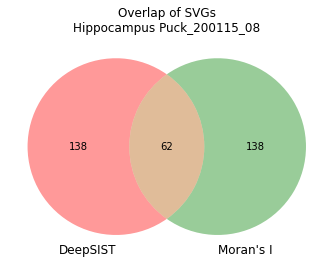

In [11]:
#N = 200

GeneInfo = pd.read_csv('GeneInfo_V1.csv', index_col = 0)
Genes_MI = GeneInfo.sort_values('MoransI', ascending = False).index.tolist()[:N]
Genes_SILE = GeneInfo.sort_values('imp_sumup_norm', ascending = False).index.tolist()[:N]

'''
n_intersect = len(set(Genes_MI).intersection(set(Genes_SILE)))

venn2(subsets = (N-n_intersect, N-n_intersect, n_intersect), set_labels = ('DeepSIST', 'Moran\'s I'))
plt.title('Overlap of SVGs\nHippocampus Puck_200115_08')
plt.savefig(save_root + 'venn_' + str(N) + '.png', bbox_inches='tight')
'''

In [22]:
cmap = sns.cubehelix_palette(n_colors = 32,start = 2, rot=1.5, as_cmap = True)

def MIBar(Score, x_label, title, output, cutoff = 0.05, N = 45):
    
    fig, ax = plt.subplots(figsize = (30, 15))
    
    ax.barh(list(range(N, 0, -1)),
            Score.values[:N],
            tick_label = Score.index.tolist()[:N]
           )
    
    plt.xlabel(x_label, fontsize = 20)
    #plt.title(title, fontsize = 20)
    
    H_index = list(np.array(range(N))[(Score < cutoff)[:N]])
    
    plt.plot([cutoff, cutoff], [-1, N + 1], color = 'red', linestyle='dotted')
    
    for i in H_index:
        ax.get_yticklabels()[i].set_color("red")
    
    plt.savefig(save_root + output + '.png', bbox_inches = 'tight')
    
    return Score.index[Score < cutoff].tolist(), Score.index[Score >= cutoff].tolist()

def DrawGenes5(adata, Genes, GeneInfo, title = '', output = ''):
    
    fig, axes = plt.subplots(4, 4, figsize = (40, 32))

    for i in range(16):
        
        im = axes[i // 4][i % 4].scatter(adata.obs['xcoord'],\
                                         adata.obs['ycoord'],\
                                         s = 2,\
                                         c = adata[:, Genes[i]].X.toarray().flatten(),\
                                         cmap = cmap)

        SS = GeneInfo.loc[Genes[i], 'imp_sumup_norm']
        MI = GeneInfo.loc[Genes[i], 'MoransI']
        axes[i//4][i%4].set_title(Genes[i] + '. ' + "DS:%.2f.MI:%.2f"%(SS, MI), fontsize=40)
        axes[i//4][i%4].get_xaxis().set_visible(False)
        axes[i//4][i%4].get_yaxis().set_visible(False)
        
        #axes[i//4][i%4].set_xlim([650, 5750])
        #axes[i//4][i%4].set_ylim([650, 5750])
        fig.colorbar(im, ax= axes[i//4][i%4])
    
    plt.tight_layout()
    #plt.suptitle(title, y = 0.92, fontsize = 30)
    plt.savefig(save_root + output + '.png', bbox_inches = 'tight')

In [ ]:
GeneInfo = GeneInfo.sort_values('imp_sumup_norm', ascending = False)
SSUGs, SSJGs = MIBar(GeneInfo['MoransI'], x_label = 'Moran\'s I',
                      title='Top 60 DeepSIST Score Gene', output='TopDSGs',
                      cutoff = 0.05, N = 60)

DrawGenes5(adata = adata, Genes = SSUGs, GeneInfo = GeneInfo,
           title = 'Top DeepSIST Score Genes (MI<0.05)', output = 'SSUGs')
DrawGenes5(adata = adata, Genes = SSJGs, GeneInfo = GeneInfo,
           title = 'Top DeepSIST Score Genes (MI>=0.05)', output = 'SSJGs')

In [ ]:
GeneInfo = GeneInfo.sort_values('MoransI', ascending = False)
MIUGs, MIJGs = MIBar(GeneInfo['imp_sumup_norm'], x_label = 'Normalized DeepSIST Score',
                      title='Top 60 Moran\'I SVGs', output='TopMSVGs',
                      cutoff = 0.05, N = 60)

DrawGenes5(adata = adata, Genes = MIUGs, GeneInfo = GeneInfo,
           title = 'Top Moran\'I SVGs (DeepSIST Score<0.05)', output = 'MIUGs')
DrawGenes5(adata = adata, Genes = MIJGs, GeneInfo = GeneInfo,
           title = 'Top Moran\'I SVGs (DeepSIST Score>=0.05)', output = 'MIJGs')